# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [35]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


**Important: Restart the Kernel at this moment**

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

# Create training set and define training dataloader
train_data = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True) 

# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I used ToTensor to convert images to tensors which is necessary for inputting data into PyTorch and normalize them to adjust the pixel values to have a mean of 0 and a standard deviation of 1 which helps stabilize learning and speed up convergence by ensuring that the input features are centered around zero

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

In [6]:
# Explore data
train_images = next(iter(train_loader))[0]
print("Train images shape:", train_images.shape)  
print("Train images size:", train_images.size) 

test_images = next(iter(test_loader))[0]
print("Test images shape:", test_images.shape) 
print("Test images size:", test_images.size) 

Train images shape: torch.Size([32, 1, 28, 28])
Train images size: <built-in method size of Tensor object at 0x7ca926784b90>
Test images shape: torch.Size([32, 1, 28, 28])
Test images size: <built-in method size of Tensor object at 0x7ca927a98110>


2


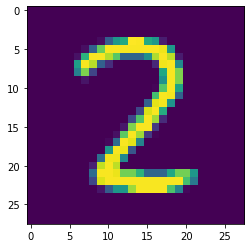

1


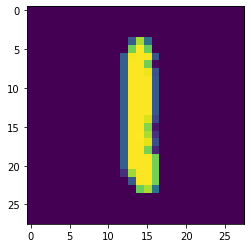

5


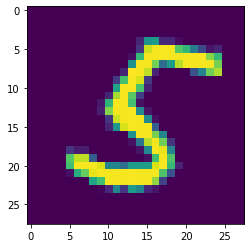

9


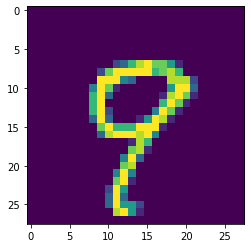

5


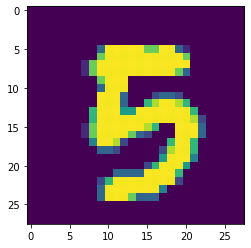

In [7]:
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [8]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.layer1 = nn.Linear(28 * 28, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [9]:
model = Classifier()
model.to(device)

Classifier(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=10, bias=True)
)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [11]:
## YOUR CODE HERE ##
num_epochs = 10

train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).float().mean().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader)*100:.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))

    val_loss = 0.0
    val_correct = 0
    model.eval()
    for inputs, labels in test_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).float().mean().item()
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader)*100:.2f}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))

Epoch 1 training accuracy: 89.08% training loss: 0.36206
Epoch 1 validation accuracy: 93.78% validation loss: 0.21109
Epoch 2 training accuracy: 94.72% training loss: 0.17556
Epoch 2 validation accuracy: 94.25% validation loss: 0.18150
Epoch 3 training accuracy: 95.88% training loss: 0.13291
Epoch 3 validation accuracy: 96.67% validation loss: 0.11154
Epoch 4 training accuracy: 96.64% training loss: 0.10819
Epoch 4 validation accuracy: 95.98% validation loss: 0.12443
Epoch 5 training accuracy: 96.97% training loss: 0.09572
Epoch 5 validation accuracy: 96.74% validation loss: 0.10762
Epoch 6 training accuracy: 97.42% training loss: 0.08237
Epoch 6 validation accuracy: 97.15% validation loss: 0.09296
Epoch 7 training accuracy: 97.51% training loss: 0.07877
Epoch 7 validation accuracy: 96.79% validation loss: 0.11077
Epoch 8 training accuracy: 97.83% training loss: 0.06770
Epoch 8 validation accuracy: 96.76% validation loss: 0.10776
Epoch 9 training accuracy: 97.94% training loss: 0.06339

Plot the training loss (and validation loss/accuracy, if recorded).

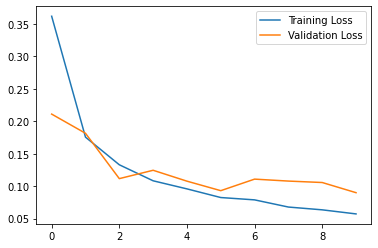

In [12]:
## YOUR CODE HERE ##
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [13]:
## YOUR CODE HERE ##
model.eval()

test_correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)

        test_correct += (predicted == labels).sum().item()

accuracy = test_correct / total * 100
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')


Accuracy of the model on the test set: 97.35%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [16]:
## YOUR CODE HERE ##

num_epochs = 15

for epoch in range(num_epochs):
    model.train()  
    train_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  
        
        outputs = model(inputs)  
        loss = criterion(outputs, labels)
        
        loss.backward() 
        optimizer.step()  
        
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training loss: {train_loss/len(train_loader):.5f}')


model.eval()  
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)  
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test set: {100 * correct / total:.2f}%')


Epoch 1 training loss: 0.02089
Epoch 2 training loss: 0.02132
Epoch 3 training loss: 0.02084
Epoch 4 training loss: 0.01814
Epoch 5 training loss: 0.02332
Epoch 6 training loss: 0.01824
Epoch 7 training loss: 0.02255
Epoch 8 training loss: 0.01849
Epoch 9 training loss: 0.01909
Epoch 10 training loss: 0.02054
Epoch 11 training loss: 0.01863
Epoch 12 training loss: 0.01900
Epoch 13 training loss: 0.01799
Epoch 14 training loss: 0.02044
Epoch 15 training loss: 0.02099
Accuracy of the model on the test set: 97.83%


## Saving your model
Using `torch.save`, save your model for future loading.

In [17]:
## YOUR CODE HERE ##
torch.save(model.state_dict(), "mnist_classifier.pth")